In [238]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from tsp import AnnealingSolver
from mst_prim import prim_mst, createRoutes
from leach import LeachSolver
from nemo import evaluate_nemo
import util
from util import lighten_color
import seaborn as sns
from util import centroid_label, ch_label, coordinator_label, worker_label, ccolor, cmarker
from topology import get_lognorm_hist
import topology

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Topology Setup

In [239]:
seed = 4
np.random.seed(seed)

avg = 50
c_capacity = 50

H, bins = get_lognorm_hist()
coords_df = topology.coords_ripe_atlas(path=topology.path_RIPE_ATLAS_filtered)
coord_dict = {"atlas": coords_df}
device_number = coords_df.shape[0]
max_resources = device_number * avg - c_capacity

df_dict_topologies = topology.create_topologies_from_dict(coord_dict, H, max_resources, c_capacity,
                                                          weights=(1, avg * 2), dist="lognorm", with_clustering=True,
                                                          kmin=2, kmax=30, kseed=10)

Creating df for atlas
Optimal k is 8
Done


In [240]:
t_label = "atlas"
prim_df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
prim_df["weight_1"] = 1
prim_df["weight_2"] = 2
coords = prim_df[["x", "y"]].to_numpy()

eval_matrix = {}
prim_df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,...,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster,weight_1,weight_2
0,202.799027,-47.855208,0.000000,coordinator,175561,0,50,50,50,50,...,50,50,50,50,50,50,50,-1,1,2
1,75.871395,-234.463748,225.684228,worker,175561,12,50,51,47,58,...,64,38,63,25,57,40,113,3,1,2
2,163.403715,-74.629814,47.632658,worker,175561,1,50,50,47,48,...,42,66,44,31,29,10,4,0,1,2
3,181.481740,7.832968,59.628850,worker,175561,2,50,48,49,47,...,44,33,36,34,74,23,8,0,1,2
4,231.431512,45.783553,97.918521,worker,175561,3,50,51,46,46,...,47,33,79,46,17,15,61,7,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,2.079037,-11.842929,203.924983,worker,175561,2,50,53,54,46,...,54,51,30,50,25,20,4,1,1,2
415,-8.101378,-47.514485,210.900681,worker,175561,1,50,49,47,50,...,42,62,31,52,48,60,162,1,1,2
416,-43.537057,-101.535160,252.117044,worker,175561,1,50,52,56,44,...,37,59,60,74,27,93,12,1,1,2
417,-50.357446,-43.098096,253.201165,worker,175561,2,50,48,56,50,...,38,62,30,77,42,58,4,1,1,2


In [241]:
# prepare rtts
prim_rtts = topology.rtt_ripe_atlas(path=topology.path_RIPE_ATLAS_filtered_RTT)
for i in range(prim_rtts.shape[0]):
    for j in range(prim_rtts.shape[0]):
        lat = prim_rtts.loc[i, j]
        if i != j and lat == 0:
            prim_rtts.loc[i, j] = int(np.linalg.norm(coords[i] - c_coords))

prim_rtts = None

In [242]:
prim_rtts

In [243]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())
colors, light_colors, palette = util.get_color_list(opt_k)
palette

Required: 2939 Available: 20950


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)]

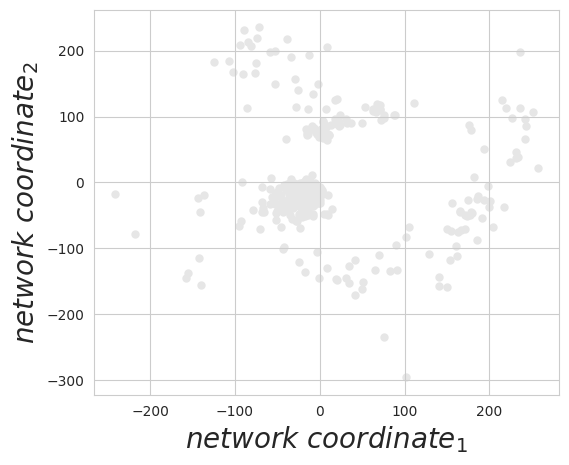

In [244]:
X_dim_def = [-50, 50]
Y_dim_def = [-60, 60]

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))
ax1 = util.plot_topology(ax1, prim_df, show_legend=False, show_coordinator=False)

#ax1.set_xlim(X_dim_def)
#ax2.set_xlim(X_dim_def)

#ax1.set_ylim(Y_dim_def)
#ax2.set_ylim(Y_dim_def)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

plt.savefig("plots/atlas/atlas_ncs_plain.svg", bbox_inches="tight")

plt.show()

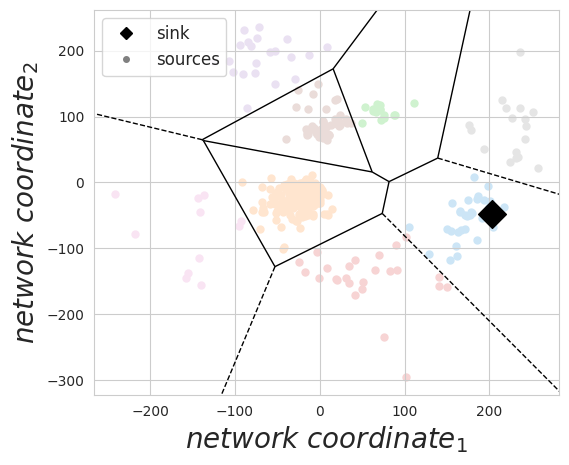

In [245]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))

ax1 = util.plot_topology(ax1, prim_df, colors, 'Topology (k=' + str(opt_k) + ")")

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

# plt.savefig("plots/atlas/atlas_ncs_colored.svg", bbox_inches="tight")

plt.show()

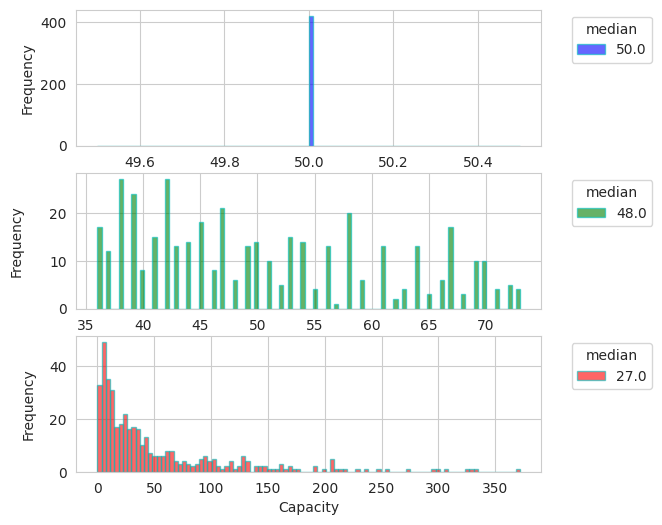

In [246]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6))

i = 100
prim_df["capacity_" + str(i)].plot.hist(ax=ax1, bins=100, alpha=0.6, color='b', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

i = 50
prim_df["capacity_" + str(i)].plot.hist(ax=ax2, bins=100, alpha=0.6, color='g', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

i = 1
prim_df["capacity_" + str(i)].plot.hist(ax=ax3, bins=100, alpha=0.6, color='r', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

ax1.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.set_xlabel("Capacity")

# Set y-axis label with padding
ax2.set_ylabel("Frequency", labelpad=18)
ax3.set_ylabel("Frequency", labelpad=10)
plt.savefig("plots/sim_1000/capacity_dist.svg", bbox_inches="tight")

plt.show()

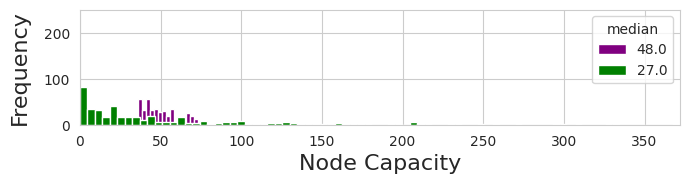

In [247]:
fig, (merged_ax) = plt.subplots(1, 1, figsize=(7, 2))

i = 50
prim_df["capacity_" + str(i)].plot.hist(ax=merged_ax, bins=15, alpha=1, color='purple',
                                        label=prim_df["capacity_" + str(i)].median())

#i = 10
#prim_df["capacity_"+str(i)].plot.hist(ax=merged_ax, bins=40, alpha=1, color='orange', label=prim_df["capacity_"+str(i)].median())

i = 1
prim_df["capacity_" + str(i)].plot.hist(ax=merged_ax, bins=80, alpha=1, color='green',
                                        label=prim_df["capacity_" + str(i)].median())

merged_ax.legend(title='median', loc='upper right')
merged_ax.set_xlabel("Node Capacity")

# Set y-axis label with padding
merged_ax.set_ylabel("Frequency", labelpad=10)

# Set the same x-axis limits for both histograms
xlim = (prim_df["capacity_1"].min(), prim_df["capacity_1"].max())
merged_ax.set_xlim(xlim)
merged_ax.set_ylim([0, 250])

merged_ax.yaxis.label.set_size(16)
merged_ax.xaxis.label.set_size(16)
#merged_ax.tick_params(axis='x', labelsize=20)

# Adjust figure layout for better display
fig.tight_layout()

plt.savefig("plots/atlas/capacity_dist.svg", bbox_inches="tight")
plt.show()

Medians from  50  to  25


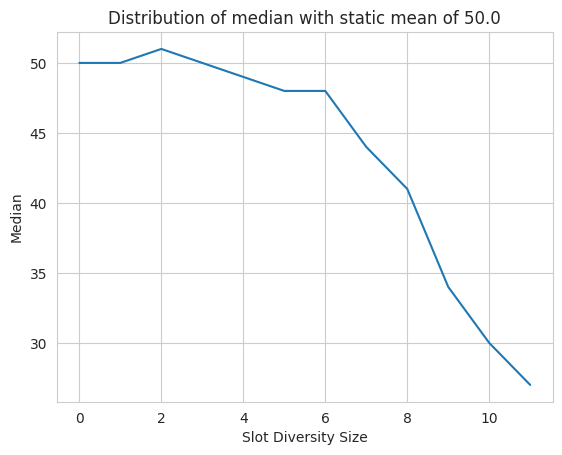

In [248]:
medians = []
mean = np.floor(prim_df["capacity_" + str(1)].mean())

for col in slot_columns:
    medians.append(prim_df[col].median())

medians = np.array(medians)
plt.plot(np.arange(len(medians)), medians)

first_med_label = "50"
last_med_label = "25"
print("Medians from ", first_med_label, " to ", last_med_label)

#print(load_dict)
plt.title("Distribution of median with static mean of " + str(mean))
plt.ylabel("Median")
plt.xlabel("Slot Diversity Size")
plt.show()

### Experiment 1: Send all data directly to coordinator


In [249]:
#first node is the coordinator
latency_hist = np.zeros(device_number)

for i in range(0, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    if prim_rtts is not None:
        lat = prim_rtts.loc[0, i]
    else:
        lat = np.linalg.norm(coords[i] - c_coords)
    latency_hist[i] = int(lat)

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    #coordinator receives 1 packet from each
    received_packets_hist[0] = received_packets_hist[0] + 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics, dtype=int)
print(df_stats)
eval_matrix["dt"] = df_stats.copy()

     latency_distribution  received_packets
0                       0               418
1                     225                 0
2                      47                 0
3                      59                 0
4                      97                 0
..                    ...               ...
414                   203                 0
415                   210                 0
416                   252                 0
417                   253                 0
418                   241                 0

[419 rows x 2 columns]


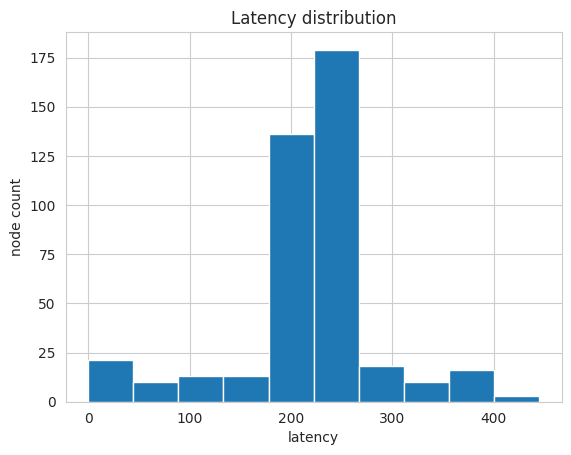

In [250]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
plt.show()

In [251]:
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"]
print("Distribution of workload: ", 1, "/", device_number, "=", round(len(df_packets) / device_number * 100, 5), "%")

Distribution of workload:  1 / 419 = 0.23866 %


### Experiment 1: LEACH Protocol

In [263]:
seed = 10
np.random.seed(seed)
latency_hist_sum = None
received_packets_hist_sum = None
leach_runs = 20
run = 1
df_stats_leach = []
num_leach_clusters = int(0.1 * device_number)

for i in range(leach_runs):
    print("LEACH run", run)
    if run == leach_runs:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords, seed=seed)
    else:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords)

    leach_labels, ch_indexes, latency_hist, received_packets_hist = leachSolver.leachClustering(df_rtt=prim_rtts,
                                                                                                rtt_eval=True,
                                                                                                rtt_clustering=True)

    if latency_hist_sum is None:
        latency_hist_sum = latency_hist
    else:
        latency_hist_sum = latency_hist_sum + latency_hist

    statistics = {"latency_distribution": latency_hist,
                  "received_packets": received_packets_hist}
    df_stats = pd.DataFrame(statistics)
    df_stats_leach.append(df_stats.copy())
    run = run + 1

print("Number of clusters = ", len(ch_indexes))
print(ch_indexes)

LEACH run 1
LEACH run 2
LEACH run 3
LEACH run 4
LEACH run 5
LEACH run 6
LEACH run 7
LEACH run 8
LEACH run 9
LEACH run 10
LEACH run 11
LEACH run 12
LEACH run 13
LEACH run 14
LEACH run 15
LEACH run 16
LEACH run 17
LEACH run 18
LEACH run 19
LEACH run 20
Number of clusters =  41
[325, 98, 292, 220, 407, 185, 287, 193, 26, 310, 27, 85, 160, 115, 297, 91, 52, 326, 290, 96, 155, 22, 203, 307, 391, 40, 177, 389, 100, 252, 84, 87, 208, 415, 386, 240, 398, 169, 20, 89, 298]


In [264]:
df_stats

,latency_distribution,received_packets
0,0.000000,41.0
1,364.459665,0.0
2,47.173015,0.0
3,129.106901,0.0
4,98.106901,0.0
...,...,...
414,209.628977,0.0
415,210.000000,5.0
416,283.491304,0.0
417,273.491304,0.0


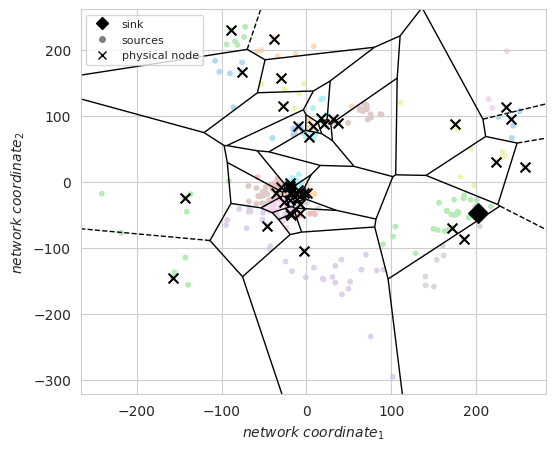

In [265]:
fig = plt.figure(figsize=(6, 5)).gca()
cluster_head_coords = coords[ch_indexes]

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

fig.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=100)
fig.scatter(cluster_head_coords[:, 0], cluster_head_coords[:, 1], s=50, color="black", marker="x", zorder=2)
fig.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.3) for x in leach_colors[leach_labels]],
            zorder=-1)

plt.legend(handles=[coordinator_label, worker_label, ch_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

vor = Voronoi(cluster_head_coords)
voronoi_plot_2d(vor, ax=fig, point_size=16, color="red", show_vertices=False, show_points=False)

plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.savefig("plots/atlas/leach.svg")
plt.show()

count    419.000000
mean     232.691242
std       70.373335
min        0.000000
25%      218.254677
50%      231.878373
75%      252.665379
max      464.211573
Name: latency_distribution, dtype: float64


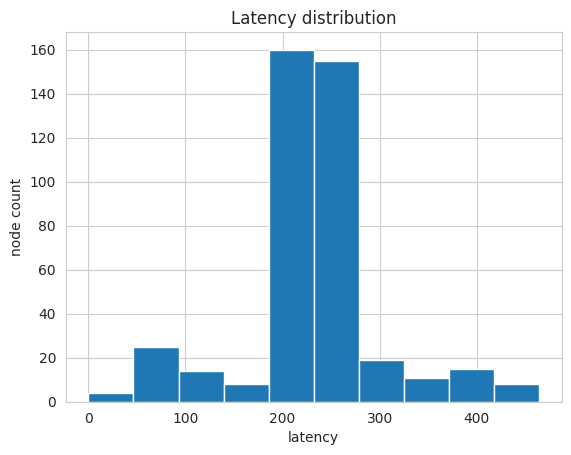

In [266]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

In [267]:
eval_matrix["leach"] = df_stats.copy()

### Experiment 2a: NEMO Aggregation with Density-based Grouping

### Identify parameters

In [257]:
# fixed params
skip = True
max_levels = 50
slot_col = "capacity_100"
weight_col = "weight_1"

# dynamic params
num_points = 9
start = 0.1
end = 0.9
hyperparam_values_1 = np.linspace(start, end, num_points)
hyperparam_values_2 = np.linspace(start, end, num_points)
X, Y = np.meshgrid(hyperparam_values_1, hyperparam_values_2)

# Initialize an array to store performance values
perc_lat_values = np.full_like(X, fill_value=np.nan)
mean_lat_values = np.full_like(X, fill_value=np.nan)

for i in range(num_points):
    if skip:
        break
    for j in range(num_points):
        eval_dict, df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, [slot_col], weight_col, merge_factor=X[i, j],
                                                                  step_size=Y[i, j], max_levels=max_levels,
                                                                  with_eval=True, df_rtt=prim_rtts)
        if limits_dict[slot_col]:
            continue

        sv = eval_dict[slot_col]["latency_distribution"].sort_values()
        perc_lat = round(sv.quantile(0.9), 2)
        mean_lat = round(sv.mean(), 2)
        print(perc_lat, mean_lat)

        perc_lat_values[i, j] = perc_lat
        mean_lat_values[i, j] = mean_lat

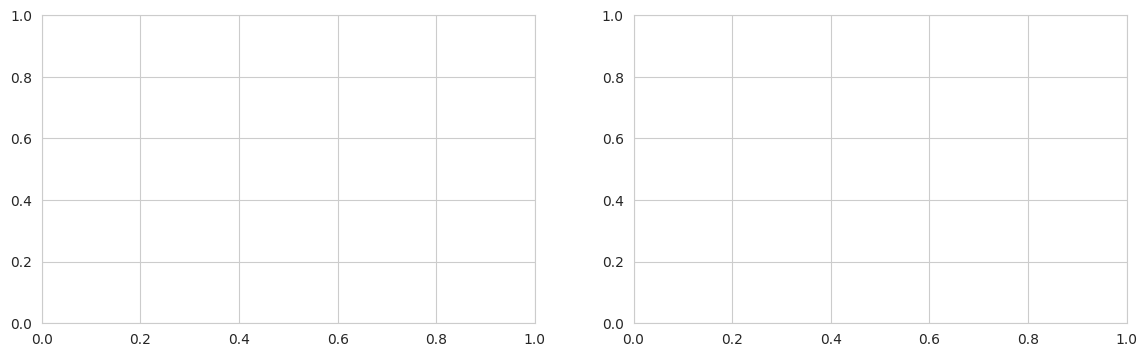

In [258]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

for i, values in enumerate([perc_lat_values, mean_lat_values]):
    if skip:
        break
    if i == 0:
        label = "latency (90P)"
    elif i == 1:
        label = "latency (mean)"
    else:
        label = "undefined"

    # Find the indices of the minimum Z value, ignoring nans
    min_index = np.unravel_index(np.nanargmin(values), values.shape)
    # Use the indices to get the corresponding X and Y values
    min_X = X[min_index]
    min_Y = Y[min_index]
    print(f"merge factor and step size for minimum {label}: (X={min_X}, Y={min_Y})", values[min_index])

    # Create a contour plot
    ax = axs[i]
    contour = ax.contourf(X, Y, values, levels=80, cmap='viridis')

    # Create a colorbar and set the label
    colorbar = plt.colorbar(contour)
    colorbar.set_label(label)

    ax.set_title(f"Performance {label}")
    ax.set_xlabel('merge factor')
    ax.set_ylabel('step size')

plt.savefig(f"plots/atlas/nemop_params_sl_{slot_col}_w_{weight_col}.png", bbox_inches="tight")
plt.show()

In [259]:
param_dict = {
    "weight_1": {"merge_factor": 0.1, "step_size": 0.8},
    "weight_2": {"merge_factor": 0.3, "step_size": 0.7},
    "weight": {"merge_factor": 0.3, "step_size": 0.4},

    "capacity_100": {
        "weight_1": {"merge_factor": 0.1, "step_size": 0.8},
        "weight_2": {"merge_factor": 0.3, "step_size": 0.7},
        "weight": {"merge_factor": 0.3, "step_size": 0.4}
    },
    "capacity_1": {
        "weight_1": {"merge_factor": 0.1, "step_size": 0.7},
        "weight_2": {"merge_factor": 0.1, "step_size": 0.8},
        "weight": {"merge_factor": 0.1, "step_size": 0.3}
    }
}

param_dict_filtered = {
    "weight_1": {"merge_factor": 0.1, "step_size": 0.8},
    "weight_2": {"merge_factor": 0.1, "step_size": 0.8},
    "weight": {"merge_factor": 0.4, "step_size": 0.3},

    "capacity_100": {
        "weight_1": {"merge_factor": 0.1, "step_size": 0.9},
        "weight_2": {"merge_factor": 0.1, "step_size": 0.8},
        "weight": {"merge_factor": 0.4, "step_size": 0.3},
    },
    "capacity_1": {
        "weight_1": {"merge_factor": 0.1, "step_size": 0.7},
        "weight_2": {"merge_factor": 0.1, "step_size": 0.8},
        "weight": {"merge_factor": 0.1, "step_size": 0.3}
    }
}

param_dict = param_dict_filtered

plt.show()

In [260]:
# for the eval for weights regarding latency
weight_cols = ["weight_1", "weight_2", "weight"]

for weight_col in weight_cols:
    eval_name = "nemo_dc" + "_" + weight_col
    eval_matrix[eval_name], df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, ["capacity_100", "capacity_1"],
                                                                           weight_col,
                                                                           merge_factor=param_dict[weight_col][
                                                                               "merge_factor"],
                                                                           step_size=param_dict[weight_col][
                                                                               "step_size"], with_eval=True,
                                                                           df_rtt=prim_rtts)

Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.8, merge_factor=0.1
Level 0 CH number:  418 Load: 418
--------Balancing load for 8 clusters to 0
Level 1 CH number:  14 Load: 14
Evaluating for capacity_100
Starting nemo for: c=capacity_1, w=weight_1, l=20, step_size=0.8, merge_factor=0.1
Level 0 CH number:  418 Load: 418
--------Balancing load for 8 clusters to 0
Level 1 CH number:  15 Load: 15
Evaluating for capacity_1
Starting nemo for: c=capacity_100, w=weight_2, l=20, step_size=0.8, merge_factor=0.1
Level 0 CH number:  418 Load: 836
--------Balancing load for 8 clusters to 0
Level 1 CH number:  20 Load: 40
Evaluating for capacity_100
Starting nemo for: c=capacity_1, w=weight_2, l=20, step_size=0.8, merge_factor=0.1
Level 0 CH number:  418 Load: 836
--------Balancing load for 8 clusters to 0
Level 1 CH number:  23 Load: 46
Evaluating for capacity_1
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.3, merge_factor=0.4
Level 0 CH number:  418 Load: 2939
--

In [261]:
# for the plots and vanilla NEMO
slot_col = "capacity_100"
weight_col = "weight_1"
eval_name = "nemo_dc_" + weight_col
df_dict_1, opt_dict_1, limits_dict_1 = evaluate_nemo(prim_df, [slot_col], weight_col, max_levels=1,
                                                     merge_factor=param_dict[weight_col]["merge_factor"],
                                                     step_size=param_dict[weight_col]["step_size"], with_eval=False)

# for the load evaluation
eval_matrix[eval_name], df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, slot_columns, weight_col,
                                                                       merge_factor=param_dict[weight_col][
                                                                           "merge_factor"],
                                                                       step_size=param_dict[weight_col]["step_size"],
                                                                       with_eval=True, df_rtt=prim_rtts)

Starting nemo for: c=capacity_100, w=weight_1, l=1, step_size=0.8, merge_factor=0.1
Level 0 CH number:  418 Load: 418
--------Balancing load for 8 clusters to 0
Level 1 CH number:  14 Load: 14
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.8, merge_factor=0.1
Level 0 CH number:  418 Load: 418
--------Balancing load for 8 clusters to 0
Level 1 CH number:  14 Load: 14
Evaluating for capacity_100
Starting nemo for: c=capacity_90, w=weight_1, l=20, step_size=0.8, merge_factor=0.1
Level 0 CH number:  418 Load: 418
--------Balancing load for 8 clusters to 0
Level 1 CH number:  14 Load: 14
Evaluating for capacity_90
Starting nemo for: c=capacity_80, w=weight_1, l=20, step_size=0.8, merge_factor=0.1
Level 0 CH number:  418 Load: 418
--------Balancing load for 8 clusters to 0
Level 1 CH number:  12 Load: 12
Evaluating for capacity_80
Starting nemo for: c=capacity_70, w=weight_1, l=20, step_size=0.8, merge_factor=0.1
Level 0 CH number:  418 Load: 418
--------Balancing load for 

In [262]:
df = df_dict[slot_col]
df

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
0,0,202.799027,-47.855208,coordinator,-1,<NA>,<NA>,<NA>,50,36,2,<NA>,14
1,1,75.871395,-234.463748,worker,3,1,0,1,50,50,0,292,0
2,2,163.403715,-74.629814,worker,0,1,0,1,50,50,0,13,0
3,3,181.481740,7.832968,worker,0,1,0,1,50,29,1,0,21
4,4,231.431512,45.783553,worker,7,1,0,1,50,50,0,283,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,414,2.079037,-11.842929,worker,1,1,0,1,50,50,0,47,0
415,415,-8.101378,-47.514485,worker,1,1,0,1,50,50,0,47,0
416,416,-43.537057,-101.535160,worker,1,1,0,1,50,50,0,253,0
417,417,-50.357446,-43.098096,worker,1,1,0,1,50,50,0,253,0


In [194]:
df[df["parent"] == 0]

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
3,3,181.481740,7.832968,worker,20,1,0,1,50,37,1,0,13
9,9,165.689312,-43.594003,worker,20,1,0,1,50,2,1,0,48
10,10,156.420368,-31.811773,worker,20,1,0,1,50,2,1,0,48
12,12,149.681367,-71.147016,worker,9,1,0,1,50,46,1,0,4
13,13,191.361077,-54.202553,worker,0,1,0,1,50,41,1,0,9
15,15,154.815523,-73.087577,worker,9,1,0,1,50,45,1,0,5
16,16,177.641182,-48.594206,worker,20,1,0,1,50,36,1,0,14
30,30,178.237463,-45.099257,worker,20,1,0,1,50,2,1,0,48
47,47,174.029098,-50.510934,worker,20,1,0,1,50,3,1,0,47
51,51,170.776972,-49.347938,worker,20,1,0,1,50,2,1,0,48


In [195]:
# check -> should be empty
df_overloaded = df.groupby(['parent'])['used_weight'].sum().copy().reset_index()
df_join = df[["oindex", "total_capacity", "free_capacity"]]
result = pd.merge(df_join, df_overloaded, left_on='oindex', right_on='parent', how='inner')
result["delta"] = result["total_capacity"] - result["used_weight"]
result[result["delta"] < 0]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [196]:
# check -> should be empty
result[result["delta"] != result["free_capacity"]]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [197]:
result

,oindex,total_capacity,free_capacity,parent,used_weight,delta
0,0,50,31,0,19,31
1,3,50,37,3,13,37
2,9,50,2,9,48,2
3,10,50,2,10,48,2
4,12,50,46,12,4,46
5,13,50,41,13,9,41
6,15,50,45,15,5,45
7,16,50,36,16,14,36
8,30,50,2,30,48,2
9,47,50,3,47,47,3


In [198]:
#create greedy aggregation tree
cluster_coords = centroids
cluster_coords_with_crd = np.column_stack((c_coords, cluster_coords.T)).T

mst = prim_mst(cluster_coords_with_crd)

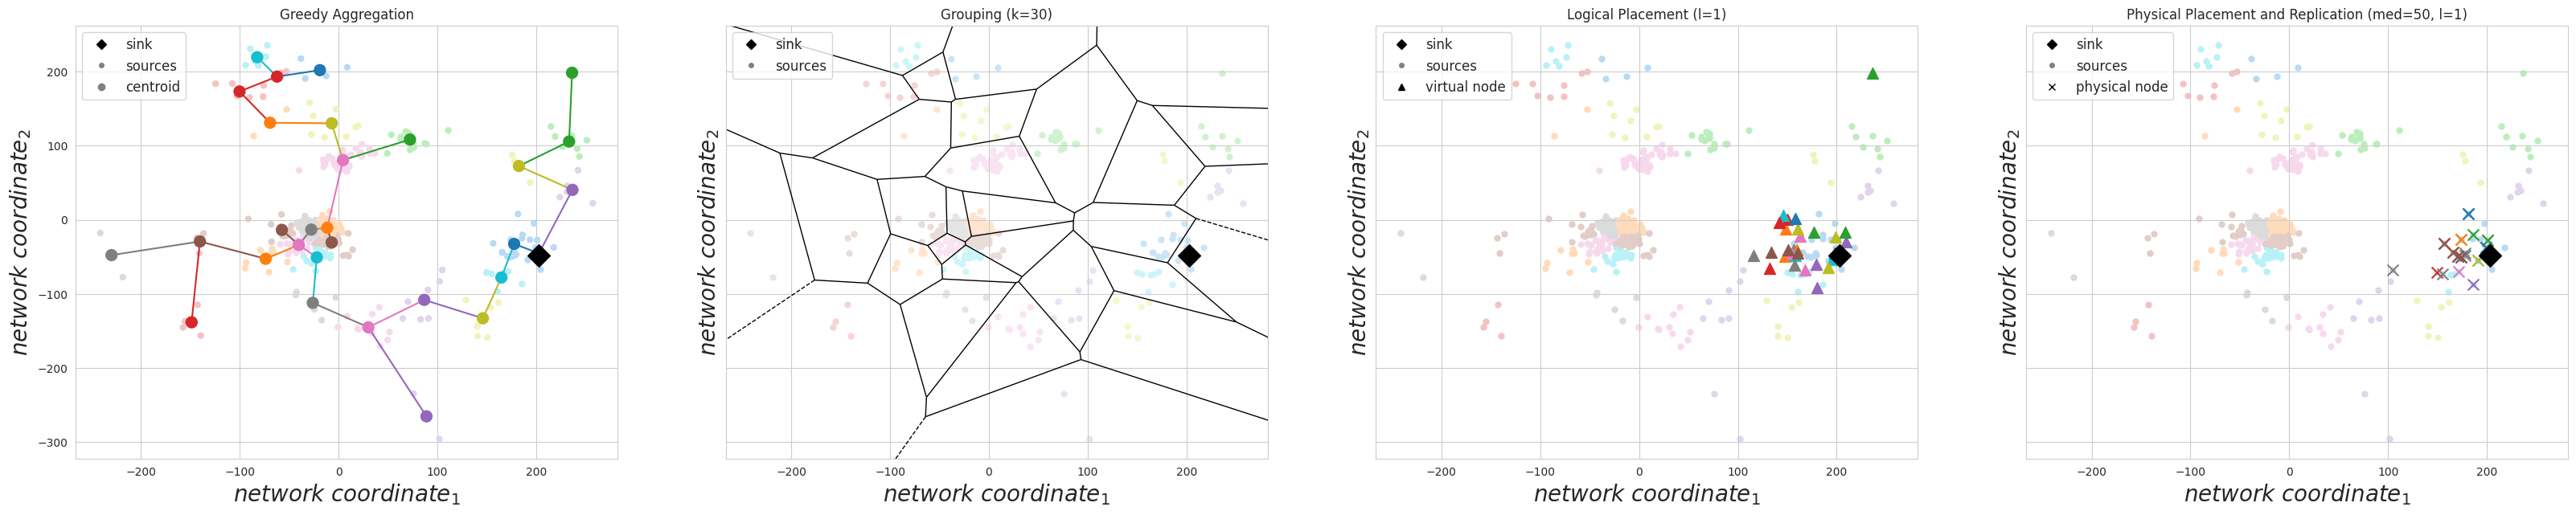

In [199]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")

lval = 0.28
leg_size = 12
symbol_size = 100
scale_fac = 0.25
axis_label_size = 20

labels = prim_df["cluster"]

# plot greedy approach from MST
for i in range(1, len(mst)):
    point1 = cluster_coords_with_crd[i]
    point2 = cluster_coords_with_crd[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax1.plot(x_values, y_values, zorder=2, color=colors[i - 1])

ax1.scatter(coords[0, 0], coords[0, 1], s=2 * symbol_size, color=ccolor, marker=cmarker, zorder=10)
ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=symbol_size, color=colors[:len(cluster_coords)], zorder=3)
# in case all coords shall be plotted
ax1.scatter(coords[:, 0], coords[:, 1], s=scale_fac * symbol_size,
            color=[lighten_color(x, lval) for x in colors[labels]])

lcentroid = Line2D([], [], color="blue", marker='o', linestyle='None', label='centroid')
ax1.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1),
           fontsize=leg_size)

ax1.set_xlabel('$network$ $coordinate_1$', fontsize=axis_label_size)
ax1.set_ylabel('$network$ $coordinate_2$', fontsize=axis_label_size)
ax1.set_title('Greedy Aggregation')

#plot grouping
util.plot_topology(ax2, prim_df, colors, title='Grouping (k=' + str(opt_k) + ")", plot_voronoi=True, leg_size=leg_size,
                   symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size)

#plot logical nodes (optima) of different groups
# util.plot2(ax3, prim_df, df_dict[slot_col], colors, lval=lval, show_centroids=True)
util.plot_optimum(ax3, prim_df, opt_dict[slot_col], colors, lval=lval, plot_centroid=False, plot_lines=False,
                  leg_size=leg_size, symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size)
# plot physical nodes
util.plot(ax4, prim_df, df_dict_1[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=False,
          leg_size=leg_size, symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size)

plt.xlim(X_dim)
plt.ylim(Y_dim)
ax3.set_title("Logical Placement (l=1)")
ax4.set_title("Physical Placement and Replication (med=" + first_med_label + ", l=1)")

plt.savefig("plots/atlas/nemo_phases.svg", bbox_inches="tight")
plt.show()

Starting nemo for: c=capacity_10, w=weight_2, l=1, step_size=0.8, merge_factor=0.1
Level 0 CH number:  418 Load: 836
--------Balancing load for 30 clusters to 0
Clusters processed: 20
Level 1 CH number:  23 Load: 46
Starting nemo for: c=capacity_10, w=weight_2, l=2, step_size=0.8, merge_factor=0.1
Level 0 CH number:  418 Load: 836
--------Balancing load for 30 clusters to 0
Clusters processed: 20
Level 1 CH number:  23 Load: 46
Starting nemo for: c=capacity_10, w=weight_2, l=3, step_size=0.8, merge_factor=0.1
Level 0 CH number:  418 Load: 836
--------Balancing load for 30 clusters to 0
Clusters processed: 20
Level 1 CH number:  23 Load: 46


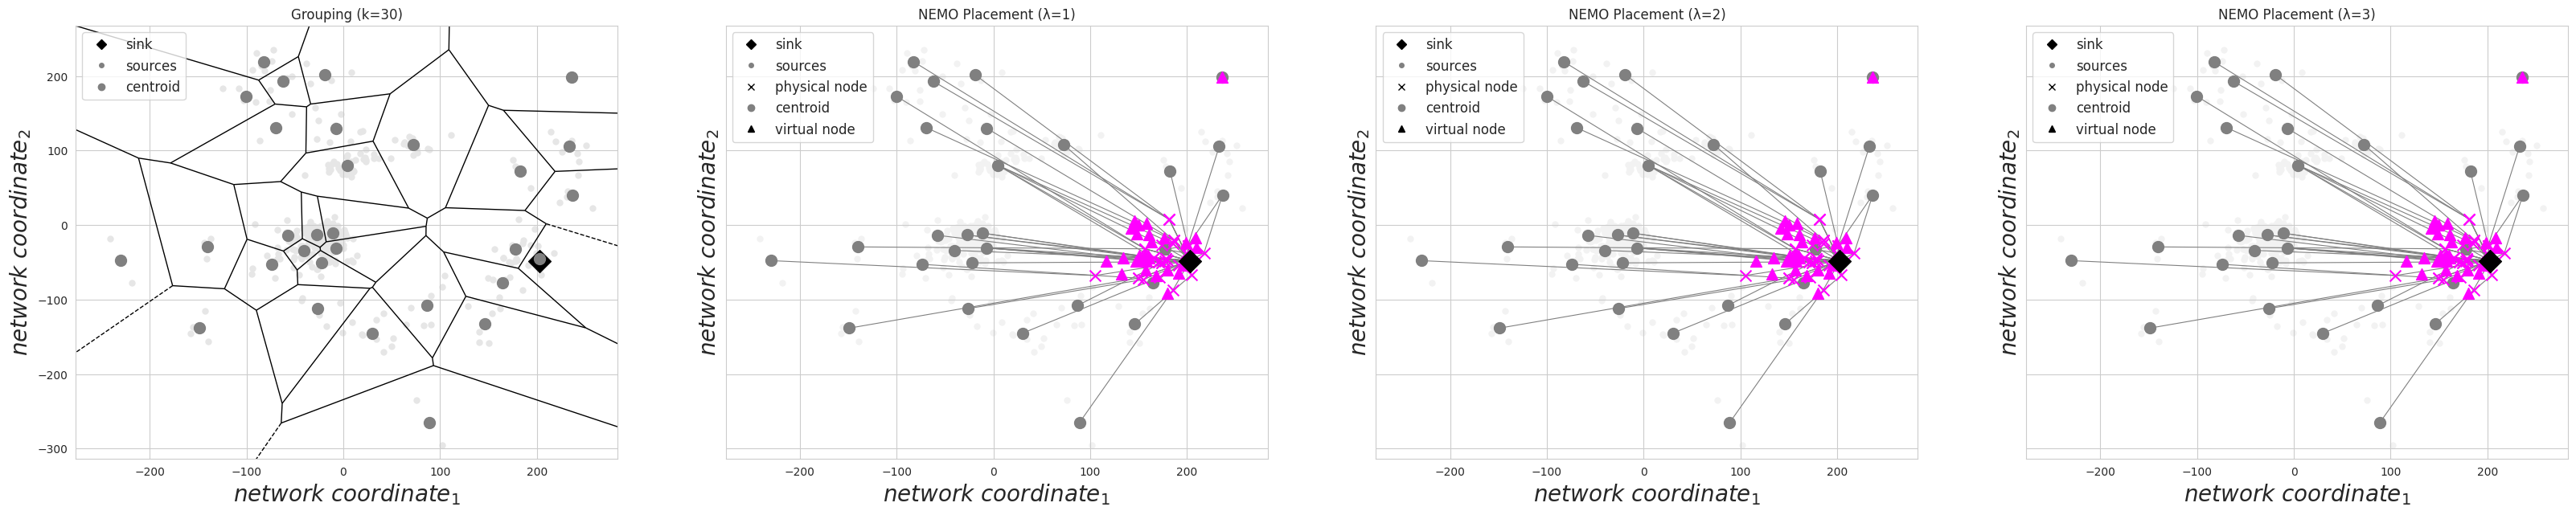

In [200]:
levels = [1, 2, 3]
fig, axs = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.1
weight_col_plot = "weight_2"
slot_col_plot = "capacity_10"
single_color = "grey"

util.plot_topology(axs[0], prim_df, None, title='Grouping (k=' + str(opt_k) + ")", plot_voronoi=True,
                   plot_centroid=True, leg_size=leg_size,
                   symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size,
                   point_color=single_color, centroid_color=single_color)

for i, level in enumerate(levels):
    df_dict_i, opt_dict_i, limits_dict_i = evaluate_nemo(prim_df, [slot_col_plot], weight_col_plot,
                                                         merge_factor=param_dict[weight_col_plot]["merge_factor"],
                                                         step_size=param_dict[weight_col_plot]["step_size"],
                                                         max_levels=level, with_eval=False)

    util.plot_with_single_color(axs[i + 1], prim_df, df_dict_i[slot_col_plot], single_color,
                                opt_dict=opt_dict_i[slot_col_plot], leg_size=leg_size, symbol_size=symbol_size,
                                scale_fac=scale_fac, axis_label_size=axis_label_size, lval=lval, plot_centroids=True,
                                plot_lines=True, highlight_color="magenta")
    axs[i + 1].set_title(f"NEMO Placement (λ={str(level)})")

plt.show()

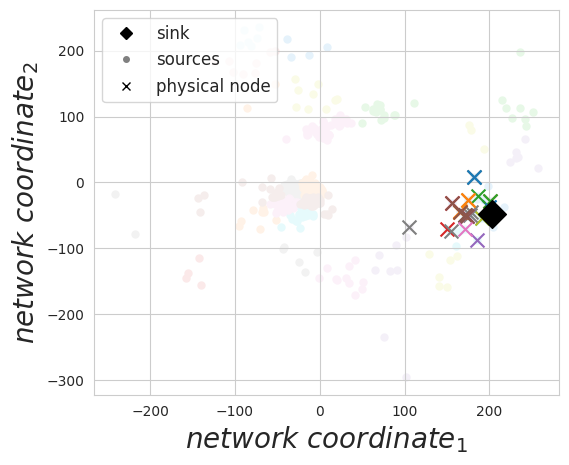

In [201]:
ax = plt.figure(figsize=(6, 5)).gca()

#uncomment this to plot nemo grouping
#ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
#ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
#ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)
#ax2.set_title('Grouping (k=' + str(opt_k) + ")")
#fig.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

#uncomment this for nemo placement
util.plot(ax, prim_df, df_dict_1[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=False)

#uncomment this for nemo redistribution
#util.plot(fig, new_paths_flat[slot_col], agg_dict_flat[slot_col], c_coords, cluster_coords, coords, colors, labels, changed_labels=reassigned_clussters, lval=lval)


ax.set_xlabel('$network$ $coordinate_1$')
ax.set_ylabel('$network$ $coordinate_2$')

plt.savefig("plots/atlas/nemo_placement.svg", bbox_inches="tight")

Distribution of workload:  5.0119 %


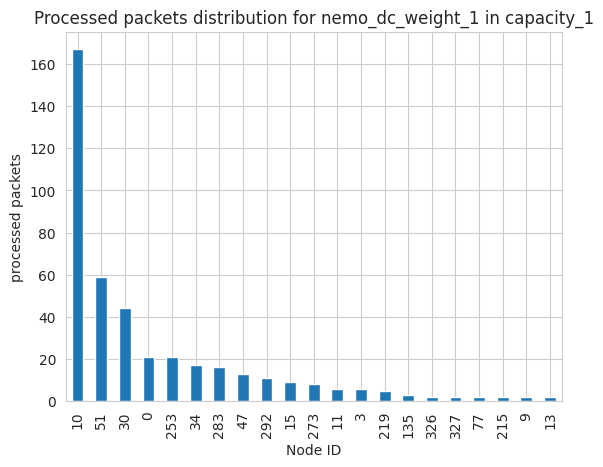

In [202]:
eval_col = list(eval_matrix[eval_name])[-1]
df_stats = eval_matrix[eval_name][eval_col]
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
df_packets.plot.bar()

print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")
plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution for " + eval_name + " in " + str(eval_col))
plt.show()

### Experiment 3: Calculating the minimimal chain which is equivallent to the TSP
#### Corresponds to to the optimal chain of chain-based protocol solutions like PEGASIS or CREEC

In [203]:
# the adjacency matrix for the plane
df = prim_df.copy()
t_coords = coords[0::]
solver = AnnealingSolver()
route, valueBest, nCities, recordBest, recordNow = solver.solve_tsp(t_coords, df_rtt=prim_rtts)

i:0, t(i):10.00, valueNow:30446.0, valueBest:30446.0
i:10, t(i):3.49, valueNow:21234.0, valueBest:21234.0
i:20, t(i):1.22, valueNow:18381.0, valueBest:18380.0
i:30, t(i):0.42, valueNow:17193.0, valueBest:17193.0
i:40, t(i):0.15, valueNow:15726.0, valueBest:15726.0
i:50, t(i):0.05, valueNow:15173.0, valueBest:15173.0
i:60, t(i):0.02, valueNow:14714.0, valueBest:14714.0


In [204]:
print(route)

[ 17  32 261  61 124 141 412 110 240 295 243 346 275 376 387 305 304 343
  58 313 129 331 293 105 401 383 237 188 267   8  52 218  31   4 322  50
 325  26  27 399 175  35 107 154  18  78 335 282 380 402 339 158 149 138
 177  42 185 122 405 338 109 220 413 382 374 358 411 101 357 363 359 362
 361 354 260 180 189 274 270 269 140 197 176 373 307 353 384 414 345 388
 296  96 318 310  53 347 271 235 256 117 159 156 167 341 196 115 340 126
 150 336 193  98 344 195 184 144  97 166 371 236 375 106 299 390 157 381
 303 418  83 417 365 152 324 292  16  51 253   2  12   9  30  13   0 323
  79  11 327  34 102   3  10  21 139 131 300 351 385  14  29 216 165 266
 231 289 227 403  82 118  70 352 284 190 257 100  67 332 250 397 389 386
 239  28  75 404 247 116 330 264 163  59 210  62 268  86  19  33 169 223
  90  64  22 228  73 161  45 241 377  81 279 360   1  80 179 298  71  43
  88  39 104 226  24 170 181 234 125  66 294 203 172 248 147 314 130 288
  87  44 160  23 113 246 232 398 378 334 200  48 13

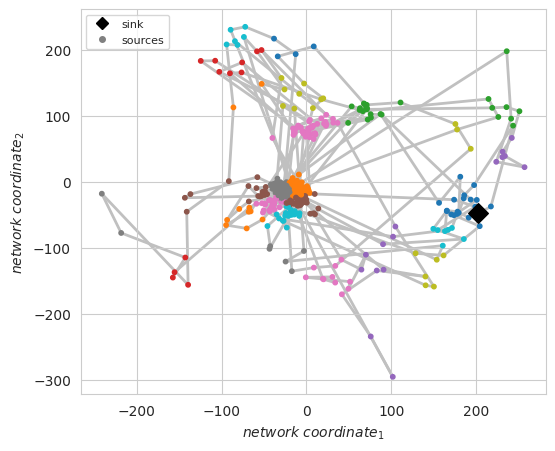

In [205]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(0, len(route) - 1):
    point1 = coords[route[i]]
    point2 = coords[route[i + 1]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=colors[labels], s=10, ax=fig)
plt.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/atlas/chain_50n.svg", bbox_inches="tight")
plt.show()

In [206]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
received_packets_hist = np.zeros(device_number)
ind_cor = np.where(route == 0)[0][0]
print("Coordinator is on place ", ind_cor, " in route.")

for i in range(0, len(route)):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = []
    if i < ind_cor:
        lat_route = route[i:ind_cor + 1]
    elif i > ind_cor:
        lat_route = route[i:ind_cor - 1:-1]
    else:
        continue

    start_idx = lat_route[0]
    received_packets_hist[lat_route[1]] += 1
    for j in range(1, len(lat_route)):
        end_idx = lat_route[j]
        if prim_rtts is not None:
            dist = dist + prim_rtts.loc[start_idx, end_idx]
        else:
            dist = dist + np.linalg.norm(coords[start_idx] - coords[end_idx])
        start_idx = end_idx
    latency_hist[i] = dist

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

Coordinator is on place  142  in route.


In [207]:
print(df_stats["received_packets"])

0      2.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
414    1.0
415    1.0
416    1.0
417    1.0
418    1.0
Name: received_packets, Length: 419, dtype: float64


count      419.000000
mean      4737.257474
std       3730.722352
min          0.000000
25%       1304.688221
50%       3821.112045
75%       7809.095101
max      11818.276572
Name: latency_distribution, dtype: float64


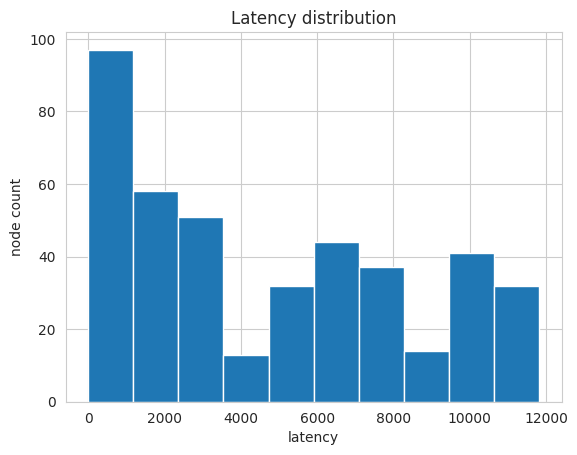

In [208]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

count    419.000000
mean       0.997613
std        0.084684
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: received_packets, dtype: float64


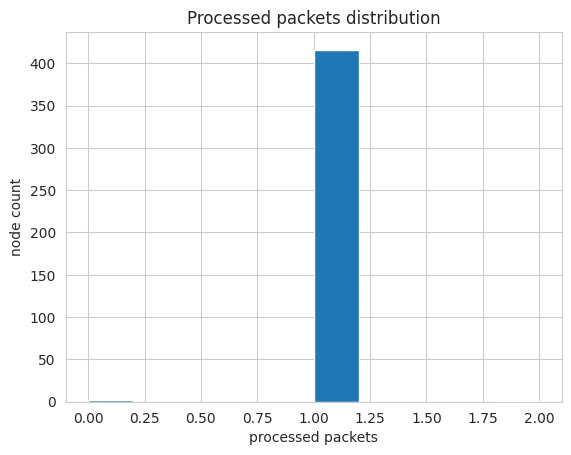

In [209]:
df_stats["received_packets"].hist()
plt.xlabel("processed packets")
plt.ylabel("node count")
plt.title("Processed packets distribution")
print(df_stats["received_packets"].describe())

eval_matrix["chain"] = df_stats.copy()

In [210]:
np.where(received_packets_hist > 1)

(array([0]),)

### Experiment 4: Calculating the minimum spanning tree like in PEDAP

In [211]:
df = prim_df.copy()
mst = prim_mst(coords, df_rtt=prim_rtts)

In [212]:
print(mst)

[-1, 360, 324, 11, 50, 81, 26, 28, 29, 253, 9, 327, 15, 0, 6, 2, 102, 170, 147, 264, 14, 291, 262, 390, 89, 378, 11, 79, 2, 27, 102, 4, 17, 250, 219, 412, 112, 307, 225, 100, 115, 158, 331, 73, 71, 230, 119, 16, 58, 65, 322, 47, 218, 258, 311, 192, 349, 213, 232, 210, 67, 139, 85, 342, 263, 334, 82, 43, 267, 272, 335, 213, 226, 155, 39, 7, 75, 152, 150, 31, 1, 75, 151, 255, 19, 86, 289, 67, 214, 61, 231, 262, 182, 249, 310, 49, 103, 296, 193, 339, 88, 348, 13, 183, 265, 220, 259, 154, 142, 18, 240, 177, 63, 387, 199, 401, 375, 374, 70, 234, 312, 164, 375, 412, 94, 401, 147, 112, 340, 58, 308, 201, 173, 380, 48, 0, 167, 286, 136, 277, 344, 123, 95, 275, 97, 385, 188, 352, 320, 158, 109, 248, 76, 82, 299, 39, 415, 187, 99, 374, 44, 211, 104, 84, 328, 267, 353, 41, 173, 228, 24, 130, 370, 115, 97, 397, 269, 138, 313, 343, 415, 98, 254, 300, 46, 405, 318, 238, 174, 179, 131, 394, 83, 144, 53, 189, 178, 176, 365, 302, 303, 141, 205, 127, 127, 36, 204, 208, 202, 214, 161, 155, 43, 212, 45, 3

In [213]:
routes = createRoutes(mst)
print(routes[2])

[324, 292, 47, 16, 102, 13, 0]


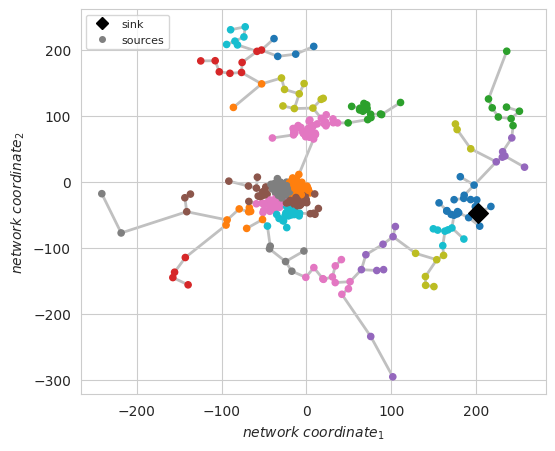

In [214]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(1, len(mst)):
    point1 = coords[i]
    point2 = coords[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=colors[labels], ax=fig)
fig.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/atlas/mst.svg", bbox_inches="tight")
plt.show()

In [215]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
for i in range(1, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = routes[i]
    start = i
    for j in range(0, len(lat_route)):
        end = lat_route[j]
        if prim_rtts is not None:
            dist = dist + prim_rtts.loc[start, end]
        else:
            dist = dist + np.linalg.norm(coords[start] - coords[end])
        start = end
    latency_hist[i] = dist

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    received_packets_hist[mst[i]] += 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

count    419.000000
mean     514.866915
std      194.477009
min        0.000000
25%      498.391633
50%      547.283055
75%      574.204635
max      951.482204
Name: latency_distribution, dtype: float64


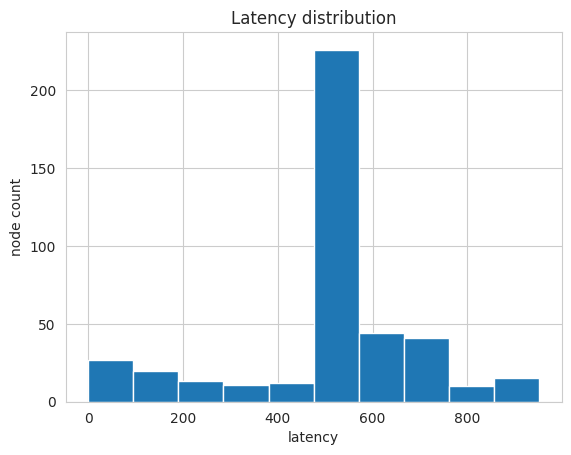

In [216]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

Distribution of workload:  78.2816 %


Text(0.5, 1.0, 'Processed packets distribution')

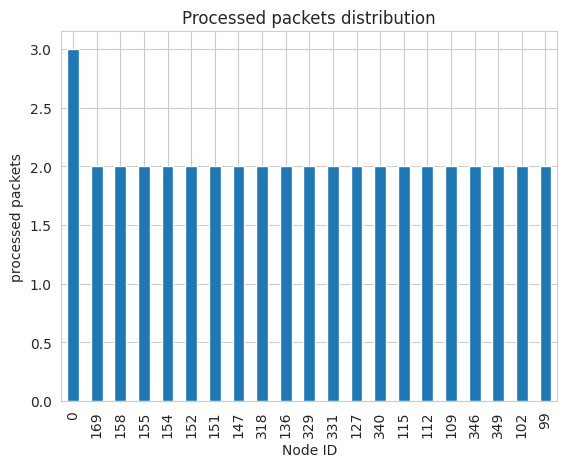

In [217]:
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")

df_packets = df_packets.head(int(round(device_number * 0.05)))
df_packets.plot.bar()

plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution")

In [218]:
eval_matrix["mst"] = df_stats.copy()

## Evaluation

In [219]:
eval_matrix.keys()

dict_keys(['dt', 'leach', 'nemo_dc_weight_1', 'nemo_dc_weight_2', 'nemo_dc_weight', 'chain', 'mst'])

In [220]:
aggregation_fams = ["dt", "leach", "mst", "chain"]
heterogen_appr = ['nemo_dc_weight_1', 'nemo_dc_weight_2', 'nemo_dc_weight']

#### Latency

In [221]:
heterogen_appr

['nemo_dc_weight_1', 'nemo_dc_weight_2', 'nemo_dc_weight']

In [222]:
colors_eval, light_colors_eval, palette_eval = util.get_color_list(11)

eval_colors = {
    "dt": colors_eval[0],
    "leach": colors_eval[1],
    "mst": colors_eval[2],
    "chain": colors_eval[3],
    "nemo": colors_eval[4],
    "nemo_base": colors_eval[4],
    "nemo_dc_base": colors_eval[4],
    "NEMO_base": colors_eval[4],
    "nemo_rc": colors_eval[5],
    "nemo_rc_base": colors_eval[5],
    "nemo (rdm groups)_base": colors_eval[5],
    "NEMO+redistribution": colors_eval[6],
    "nemo_pen": colors_eval[7],
    "nemo_pen_base": colors_eval[8],
    "nemo_dc_weight_1": colors_eval[6],
    "nemo_dc_weight_2": colors_eval[9],
    "nemo_dc_weight": colors_eval[10]
}

renaming_dict = {
    "nemo_dc_weight_1": "nemo (w=1,",
    "nemo_dc_weight_2": "nemo (w=2,",
    "nemo_dc_weight": "nemo (w=ln[1, 50],",
    "capacity_100": "m=" + first_med_label,
    "capacity_1": "m=" + last_med_label
}

In [223]:
eval_matrix["dt"]["latency_distribution"].mean()

218.05727923627686

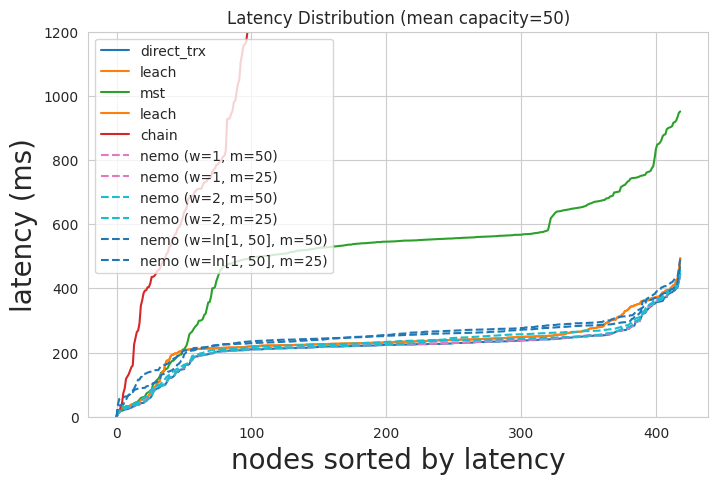

Means:  {'dt': 218.06, 'leach': 235.0, 'mst': 514.87, 'chain': 4737.26, 'nemo (w=1, m=50)': 219.42, 'nemo (w=1, m=25)': 219.95, 'nemo (w=2, m=50)': 221.2, 'nemo (w=2, m=25)': 229.9, 'nemo (w=ln[1, 50], m=50)': 253.56, 'nemo (w=ln[1, 50], m=25)': 246.95}
Quantiles:  {'dt': 270.0, 'leach': 323.42, 'mst': 721.45, 'chain': 10421.02, 'nemo (w=1, m=50)': 270.49, 'nemo (w=1, m=25)': 273.02, 'nemo (w=2, m=50)': 275.52, 'nemo (w=2, m=25)': 281.7, 'nemo (w=ln[1, 50], m=50)': 312.84, 'nemo (w=ln[1, 50], m=25)': 294.41}


In [224]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

#plot baselines
for l in ["dt", "leach", "mst", "leach", "chain"]:
    orl = l
    sv = eval_matrix[l]["latency_distribution"].sort_values()
    #print("Mean latency ", l, ": ", round(eval_matrix[l]["latency_distribution"].mean(), 2))
    quant_dict[l] = round(eval_matrix[l]["latency_distribution"].quantile(0.9), 2)
    mean_dict[l] = round(eval_matrix[l]["latency_distribution"].mean(), 2)

    if l == "dt":
        l = "direct_trx"
    sv.plot(ax=ax1, linestyle="-", use_index=False, label=l, color=eval_colors[orl])

for approach in heterogen_appr:
    cl = approach
    emat = eval_matrix[approach]

    for capacity, df in emat.items():
        if capacity not in ["capacity_100", "capacity_1"]:
            continue
        l = renaming_dict[approach] + " " + renaming_dict[capacity] + ")"

        sv = df["latency_distribution"]
        sv = sv.sort_values()

        quant_dict[l] = round(sv.quantile(0.9), 2)
        mean_dict[l] = round(sv.mean(), 2)
        sv.plot(ax=ax1, use_index=False, label=l, color=eval_colors[cl], linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
# Display a figure.
plt.ylim([0, 1200])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

#### Heterogeneity

In [268]:
aggregation_fams

['dt', 'leach', 'mst', 'chain']

In [269]:
eval_matrix_load = eval_matrix.copy()
eval_matrix_load.pop("nemo_dc_weight_2")
eval_matrix_load.pop("nemo_dc_weight")
eval_matrix_load.keys()

dict_keys(['dt', 'leach', 'nemo_dc_weight_1'])

In [270]:
load_dict = {}
nn_dict = {}

for k, df in eval_matrix_load.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in slot_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in slot_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

In [271]:
load_dict

{'dt': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'leach': [0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.1, 0.0, 0.05, 0.9, 3.1, 10.1]}

In [272]:
load_dict = {}
nn_dict = {}

for k, df in eval_matrix_load.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in slot_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in slot_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

for k, mat in eval_matrix_load.items():
    if k in heterogen_appr:
        slot_list = []
        nn_list = []
        for colname in slot_columns:
            df = mat[colname]
            df["av_capacity"] = prim_df[colname] - df["received_packets"]
            tmp_df_sl = df[df["av_capacity"] < 0]
            tmp_df_nn = df[df["av_capacity"] >= 0]
            slot_list.append(tmp_df_sl["av_capacity"].count())
            nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

#for k, mat in eval_matrix.items():
#    if k in heterogen_appr:
#        slot_list = []
#        nn_list = []
#        for colname in slot_columns:
#            df = mat["base"]
#            df["av_capacity"] = prim_df[colname] - df["received_packets"]
#            tmp_df_sl = df[df["av_capacity"] < 0]
#            tmp_df_nn = df[df["av_capacity"] >= 0]
#            slot_list.append(tmp_df_sl["av_capacity"].count())
#            nn_list.append(tmp_df_nn["av_capacity"].count())
#        load_dict[k + "_base"] = slot_list
#        nn_dict[k + "_base"] = nn_list

In [273]:
load_dict.keys()

dict_keys(['dt', 'leach', 'nemo_dc_weight_1'])

In [274]:
agg_arr1 = []
for fam in load_dict.keys():
    agg_arr1.append(load_dict[fam])
    print("Fam: ", fam)
    print(load_dict[fam])

#agg_arr2 = []
#for fam in eval_matrix_load.keys():
#    agg_arr2.append(load_dict[fam + "_base"])
#mr = np.mean(np.array(agg_arr2), axis=0)
#load_dict["NEMO_base"] = mr
#print(mr)

Fam:  dt
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Fam:  leach
[0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.1, 0.0, 0.05, 0.9, 3.1, 10.1]
Fam:  nemo_dc_weight_1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


dt [50. 50. 51. 50. 49. 48. 48. 44. 41. 34. 30. 27.]
dt [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
leach [50. 50. 51. 50. 49. 48. 48. 44. 41. 34. 30. 27.]
leach [0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.1, 0.0, 0.05, 0.9, 3.1, 10.1]
nemo_dc_weight_1 [50. 50. 51. 50. 49. 48. 48. 44. 41. 34. 30. 27.]
nemo_dc_weight_1 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


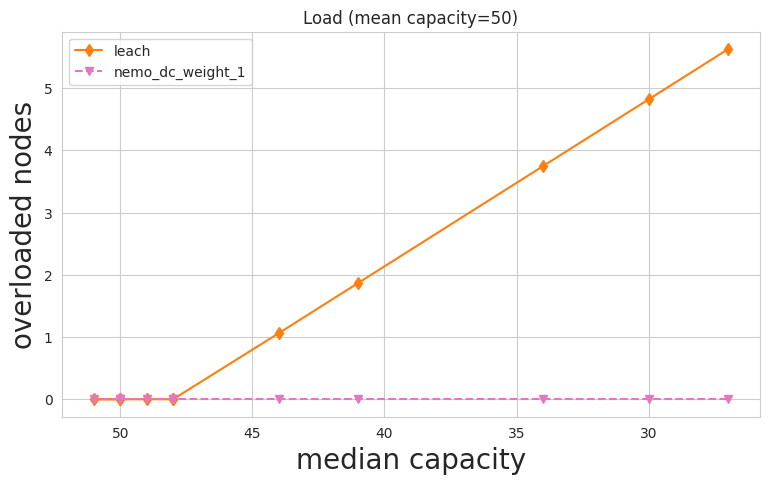

In [275]:
fig, ax = plt.subplots(figsize=(9, 5))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in load_dict.keys():
    vals = load_dict[fam]
    evcol = fam
    print(fam, medians)
    print(fam, vals)
    m, b = np.polyfit(medians, vals, 1)
    if fam == "dt":
        fam = "direct_trx"
        continue
    if fam == "nemo_dc":
        fam = "nemo"
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median capacity")
ax.set_ylabel("overloaded nodes")
#ax.set_yscale('log')
ax.legend()

ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

plt.savefig("plots/atlas/eval_load_abs.svg")
ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()

In [276]:
load_dict.keys()

dict_keys(['dt', 'leach', 'nemo_dc_weight_1'])

leach - d #ff7f0e : [0.0, 0.0, 0.0, 0.24390243902439024, 0.0, 0.0, 0.24390243902439024, 0.0, 0.12195121951219512, 2.1951219512195124, 7.560975609756097, 24.634146341463413]
nemo_dc_weight_1 -- v #e377c2 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


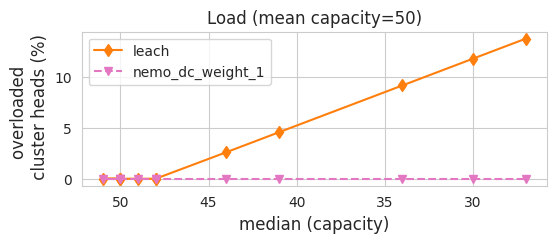

In [277]:
fig, ax = plt.subplots(figsize=(6, 2))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in load_dict.keys():
    vals = load_dict[fam]
    evcol = fam
    if fam == "dt":
        fam = "direct_trx"
        vals = [100 for x in vals]
        continue
    if fam == "leach":
        vals = [x / num_leach_clusters * 100 for x in vals]
    if fam == "mst":
        agg_points = (device_number - 1) / 2
        vals = [x / agg_points * 100 for x in vals]
    if fam == "chain":
        agg_points = device_number - 2
        vals = [x / agg_points * 100 for x in vals]
    if fam == "nemo_dc":
        fam = "nemo"
    m, b = np.polyfit(medians, vals, 1)
    print(fam, styles[i], markers[i], eval_colors[evcol], ":", vals)
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median (capacity)")
ax.set_ylabel("overloaded \n cluster heads (%)")
#ax.set_yscale('log')
ax.legend()

ax.yaxis.label.set_size(12)
ax.xaxis.label.set_size(12)

plt.savefig("plots/atlas/eval_load_perc.svg")
ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()

In [278]:
quant_dict

{'dt': 270.0,
 'leach': 323.42,
 'mst': 721.45,
 'chain': 10421.02,
 'nemo (w=1, m=50)': 270.49,
 'nemo (w=1, m=25)': 273.02,
 'nemo (w=2, m=50)': 275.52,
 'nemo (w=2, m=25)': 281.7,
 'nemo (w=ln[1, 50], m=50)': 312.84,
 'nemo (w=ln[1, 50], m=25)': 294.41}

In [279]:
mean_dict

{'dt': 218.06,
 'leach': 235.0,
 'mst': 514.87,
 'chain': 4737.26,
 'nemo (w=1, m=50)': 219.42,
 'nemo (w=1, m=25)': 219.95,
 'nemo (w=2, m=50)': 221.2,
 'nemo (w=2, m=25)': 229.9,
 'nemo (w=ln[1, 50], m=50)': 253.56,
 'nemo (w=ln[1, 50], m=25)': 246.95}